In [15]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from particle import Particle, InvalidParticle, ParticleNotFound
import pdg
api = pdg.connect()


In [111]:
def get_name_from_pdgc(pdgc):
    try:
        particle = Particle.from_pdgid(abs(pdgc))
        
        particle_name = particle.name
        
        if pdgc < 0:
            if "+" not in particle_name and "-" not in particle_name:
                particle_name = f"anti-{particle_name}"
            if pdgc == -11 or pdgc == -13 or pdgc == -15:
                particle_name = particle_name.replace("-","+")  # For some reason it can't get charges right for charged leptons
        
        return particle_name
        
    except InvalidParticle:
        return f"Unknown PDG Code: {pdgc}"
    except ParticleNotFound:
        return f"Particle not found: {pdgc}"

## Initial FASERv studies with GENIE

I used the [GenieGenerator](https://gitlab.cern.ch/faser/offline/geniegenerator) repo from the FASER offline software to generate $1 \textrm{fb}^-1$ worth of neutrino interactions
I used the [`/GenieGenerator/faser/runGenerator_1.sh`](https://gitlab.cern.ch/faser/offline/geniegenerator/-/blob/faser-R-3_00_06/faser/runGenerator_1.sh?ref_type=heads) script, which I believe simulates all possible $\nu_e$, $\nu_\mu$ and $\nu_\tau$ interactions for a given geometry

I was unable to generate events with GENIE with 0.9 mm thick tungsten sheets separated by a gap of 7.08 mm (stand-in for the SCT modules). But I was able to generate events though with a 0.5 mm thick gap between the tungsten (i.e a 0.5 mm thick totally unrealistic SCT)

These are the results of using a work-around

In [16]:
faserv_current = uproot.open("../GenieOutput/FASERvSi_0.5mmThickSCT.0.gfaser.root:gFaser")
print(faserv_current.keys())

['vx', 'vy', 'vz', 'n', 'name', 'pdgc', 'status', 'firstMother', 'lastMother', 'firstDaughter', 'lastDaughter', 'px', 'py', 'pz', 'E', 'm', 'M']


In [17]:
kinematics = faserv_current.arrays(faserv_current.keys(), library='np')    

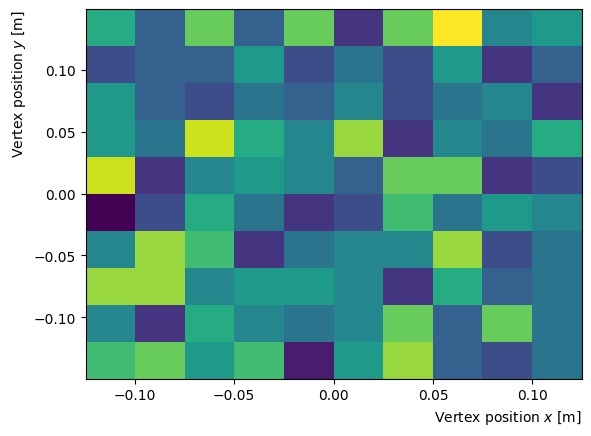

In [18]:
fig, ax = plt.subplots()
ax.hist2d(kinematics['vx'], kinematics['vy']);
ax.set_xlabel(r"Vertex position $x$ [m]", loc="right");
ax.set_ylabel(r"Vertex position $y$ [m]", loc="top");

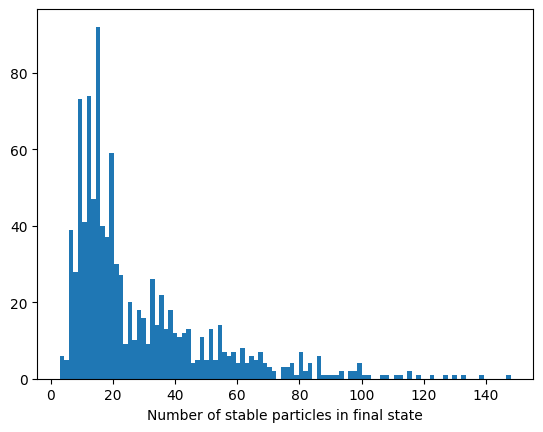

In [40]:
n_final_state_particles = []

for s in kinematics['status']:
    unique, counts = np.unique(s, return_counts=True)
    res = dict(zip(unique, counts))
    n_final_state_particles.append(res[1])

fig, ax = plt.subplots()
ax.hist(n_final_state_particles, 100);
ax.set_xlabel("Number of stable particles in final state");


In [112]:

for i in range(len(kinematics["vx"])):
    pdg_nu = kinematics["pdgc"][i][0]
    nu_name = get_name_from_pdgc(pdg_nu)
    
    daughter_particles_idx = np.where(kinematics["lastDaughter"][i] == pdg_nu)
    
    ld = kinematics["lastDaughter"][i][0]
    daughter_name = kinematics["pdgc"][i][ld]
    print(f"Initial neutrino was: {nu_name:<13} Daughter was {get_name_from_pdgc(daughter_name):<13} ({pdg_nu} --> {daughter_name})")
    


Initial neutrino was: nu(mu)        Daughter was nu(mu)        (14 --> 14)
Initial neutrino was: nu(mu)        Daughter was mu-           (14 --> 13)
Initial neutrino was: nu(mu)        Daughter was mu-           (14 --> 13)
Initial neutrino was: nu(mu)        Daughter was mu-           (14 --> 13)
Initial neutrino was: anti-nu(mu)   Daughter was anti-nu(mu)   (-14 --> -14)
Initial neutrino was: anti-nu(mu)   Daughter was anti-nu(mu)   (-14 --> -14)
Initial neutrino was: anti-nu(e)    Daughter was e+            (-12 --> -11)
Initial neutrino was: nu(mu)        Daughter was mu-           (14 --> 13)
Initial neutrino was: anti-nu(e)    Daughter was e+            (-12 --> -11)
Initial neutrino was: nu(mu)        Daughter was mu-           (14 --> 13)
Initial neutrino was: nu(mu)        Daughter was mu-           (14 --> 13)
Initial neutrino was: nu(e)         Daughter was e-            (12 --> 11)
Initial neutrino was: nu(mu)        Daughter was mu-           (14 --> 13)
Initial neutrino 

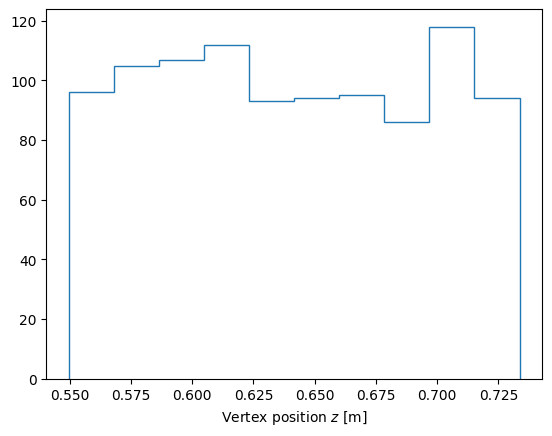

In [20]:
fig, ax = plt.subplots()
ax.hist(kinematics["vz"], histtype='step');
ax.set_xlabel(r"Vertex position $z$ [m]");

In [21]:

genie_status_code_dict = {-1: "undefined",
                          0: "initial state",
                          1: "stable final state",
                          2: "intermediate state",
                          3: "decayed state",
                          11: "nucleon target",
                          12: "DIS pre-fragmentation state",
                          13: "resonant pre-decayed state",
                          14: "hadron in nucleus",
                          15: "nuclear final state remnant",
                          16: "nucleon cluster target"}

In [53]:
def get_name_from_pdgc(pdgc):
    try:
        particle = Particle.from_pdgid(abs(pdgc))
        
        particle_name = particle.name
        
        if pdgc < 0 and "+" not in particle_name and "-" not in particle_name:
            particle_name = f"anti-{particle_name}"
        
        return particle_name
        
    except InvalidParticle:
        return f"Unknown PDG Code: {pdgc}"
    except ParticleNotFound:
        return f"Particle not found: {pdgc}"

In [23]:
i = 3
for pdgc, status in zip(kinematics["pdgc"][i], kinematics["status"][i]):
    print(f"pdg: {get_name_from_pdgc(pdgc)} --- status: {genie_status_code_dict[status]}")


pdg: nu(mu) --- status: initial state
pdg: W184 --- status: initial state
pdg: n --- status: nucleon target
pdg: W183 --- status: intermediate state
pdg: mu- --- status: stable final state
pdg: Unknown PDG Code: 2000000001 --- status: DIS pre-fragmentation state
pdg: Lambda(c)+ --- status: hadron in nucleus
pdg: Unknown PDG Code: 2000000002 --- status: DIS pre-fragmentation state
pdg: anti-d --- status: DIS pre-fragmentation state
pdg: d --- status: DIS pre-fragmentation state
pdg: Particle not found: 92 --- status: DIS pre-fragmentation state
pdg: anti-K*(892)0 --- status: DIS pre-fragmentation state
pdg: K*(892)0 --- status: DIS pre-fragmentation state
pdg: rho(770)+ --- status: DIS pre-fragmentation state
pdg: pi0 --- status: hadron in nucleus
pdg: rho(770)0 --- status: DIS pre-fragmentation state
pdg: pi+ --- status: hadron in nucleus
pdg: anti-K0 --- status: DIS pre-fragmentation state
pdg: pi0 --- status: hadron in nucleus
pdg: K+ --- status: hadron in nucleus
pdg: pi+ --- status

In [24]:
initial_states = []
neutrino_set = set()
nucleus_set = set()

for i in range(len(kinematics["pdgc"])):
    tmp = []
    for pdgc, status in zip(kinematics["pdgc"][i], kinematics["status"][i]):
        if status == 0:
            tmp.append(get_name_from_pdgc(pdgc))

    tmp.append([kinematics['vx'][i], kinematics['vy'][i], kinematics['vz'][i]])
    neutrino_set.add(tmp[0])
    nucleus_set.add(tmp[1])
    initial_states.append(tmp)
    
print(sorted(neutrino_set))
print(sorted(nucleus_set))

print(initial_states)

['anti-nu(e)', 'anti-nu(mu)', 'anti-nu(tau)', 'nu(e)', 'nu(mu)', 'nu(tau)']
['W180', 'W182', 'W183', 'W184', 'W186']
[['nu(mu)', 'W183', [np.float64(-0.040356942416105455), np.float64(0.08235951663776425), np.float64(0.6063942384855281)]], ['nu(mu)', 'W186', [np.float64(-0.05494402248763052), np.float64(0.12930833882912682), np.float64(0.6663013027441148)]], ['nu(mu)', 'W182', [np.float64(-0.08159929392693514), np.float64(0.12230968891820426), np.float64(0.7056116543178834)]], ['nu(mu)', 'W184', [np.float64(-0.02695396294949609), np.float64(-0.12662586252149108), np.float64(0.5712453088735621)]], ['anti-nu(mu)', 'W182', [np.float64(-0.10470645657616214), np.float64(-0.10019807657102729), np.float64(0.681948840360429)]], ['anti-nu(mu)', 'W183', [np.float64(0.01632018848530501), np.float64(0.06943379414032827), np.float64(0.5756015490929055)]], ['anti-nu(e)', 'W184', [np.float64(0.11744571270779157), np.float64(-0.14517954964380925), np.float64(0.6579997856791986)]], ['nu(mu)', 'W184', [

In [25]:
neutrino_dict = {value: {"count": 0, "vx": [], "vy": [], "vz": []} for value in sorted(neutrino_set)}
nucleus_dict = {value: {"count": 0, "vx": [], "vy": [], "vz": []} for value in sorted(nucleus_set)}

# for x in initial_states:
#     print(x)

for x in initial_states:
    
    if type(x[2]) is str:
        continue
    
    neutrino = x[0]
    nucleus = x[1]
    vx = x[2][0]
    vy = x[2][1]
    vz = x[2][2]    
    
    neutrino_dict[neutrino]["count"] += 1
    neutrino_dict[neutrino]["vx"].append(vx)
    neutrino_dict[neutrino]["vy"].append(vy)
    neutrino_dict[neutrino]["vz"].append(vz)
    
    nucleus_dict[nucleus]["count"] += 1
    nucleus_dict[nucleus]["vx"].append(vx)
    nucleus_dict[nucleus]["vy"].append(vy)
    nucleus_dict[nucleus]["vz"].append(vz)

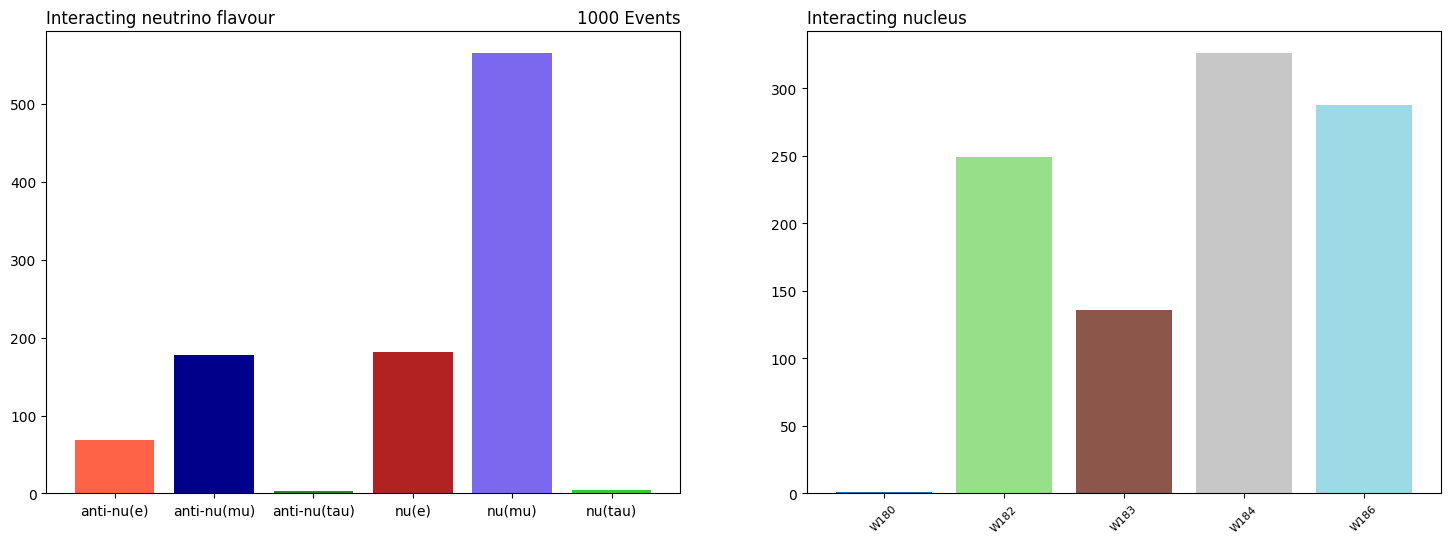

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

neutrino_labels = neutrino_dict.keys()
neutrino_count = [c["count"] for c in neutrino_dict.values()]


nucleus_labels =nucleus_dict.keys()
nucleus_count = [c["count"] for c in nucleus_dict.values()]

ax[0].set_title("Interacting neutrino flavour", loc='left')
# ax[0].set_title(r"Luminosity = 1 $\text{fb}^{-1}$", loc='right')
ax[0].set_title(r"1000 Events", loc='right')
ax[0].bar(range(len(neutrino_labels)), neutrino_count, tick_label=neutrino_labels, color=[ "tomato", "darkblue", "forestgreen", "firebrick", "mediumslateblue", "limegreen"])

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

ax[1].set_title("Interacting nucleus", loc='left')
# ax[1].set_title(r"Luminosity = 1 $\text{fb}^{-1}$", loc='right')
ax[0].set_title(r"1000 Events", loc='right')
ax[1].bar(range(len(nucleus_labels)), nucleus_count, tick_label=nucleus_labels, color=colors);
ax[1].set_xticks(range(len(nucleus_labels)), rotation=45, labels=nucleus_labels, fontsize=8);

# plt.savefig("FaserNu3.gdml-1fb-dominant-interactions.pdf")

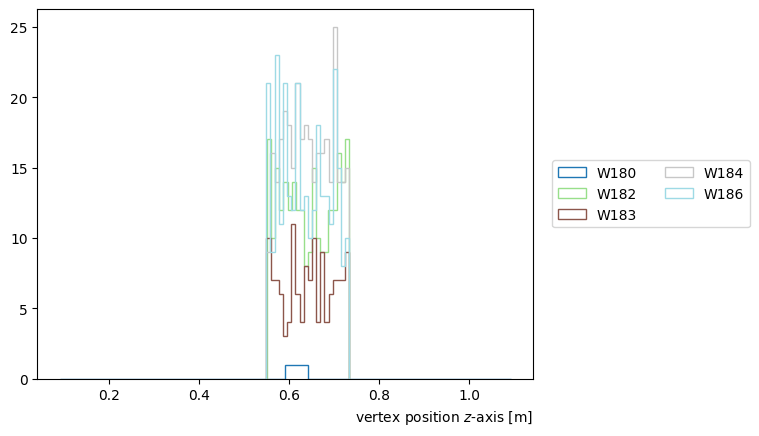

In [27]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
plt.savefig("FaserNu3.gdml-nuclus-zpos.pdf")
     

Total number of events in FASERv: 0


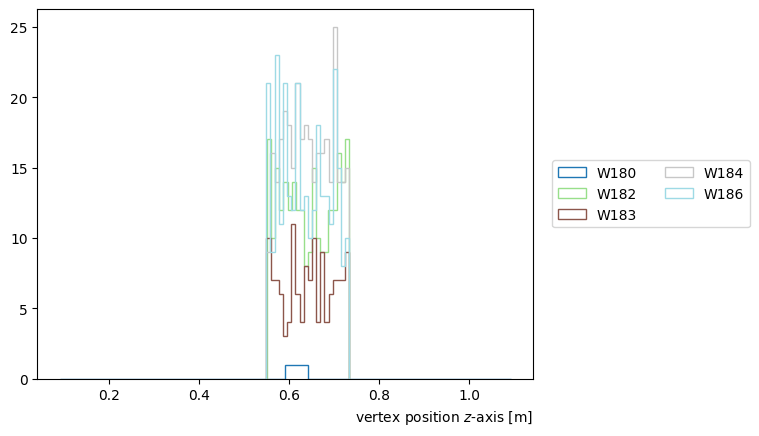

In [28]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

total_events_in_faserv = 0

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "W" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])
        
        for vz in nucleus_data['vz']:
            if vz < -1:
                total_events_in_faserv += 1 
        
ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")

# That last peak is presumably the preshower (it has a tungsten layer)

print(f"Total number of events in FASERv: {total_events_in_faserv}")
     

/tmp/ipykernel_13896/2502236852.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))


Text(1, 0, 'vertex position $z$-axis [m]')

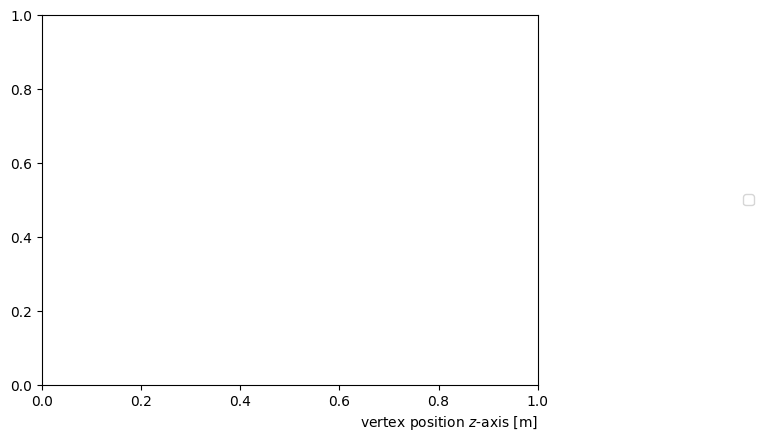

In [29]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "p" in nucleus_name or "Pb" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     

/tmp/ipykernel_13896/1933981621.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))


Text(1, 0, 'vertex position $z$-axis [m]')

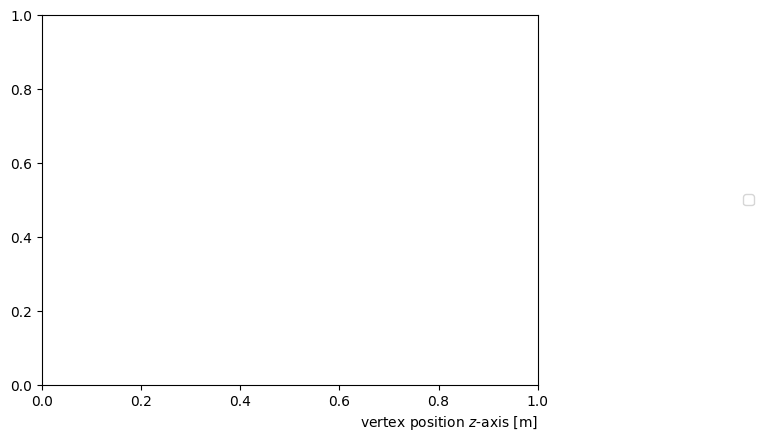

In [30]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "Nd" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     

/tmp/ipykernel_13896/1827611266.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))


Text(1, 0, 'vertex position $z$-axis [m]')

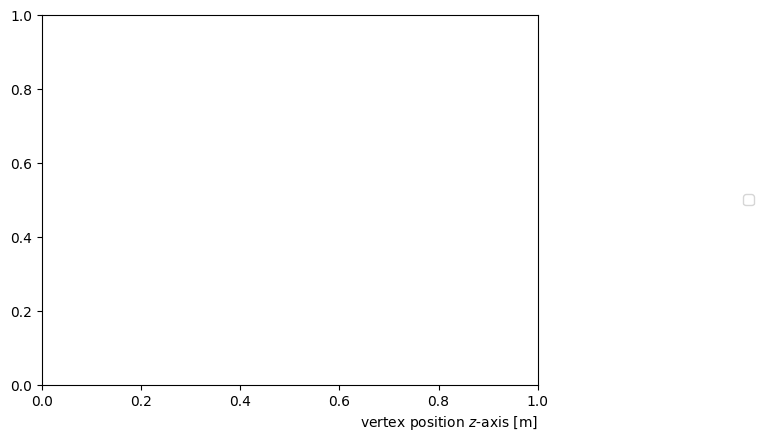

In [31]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "Fe" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     

/tmp/ipykernel_13896/3382607599.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))


Text(1, 0, 'vertex position $z$-axis [m]')

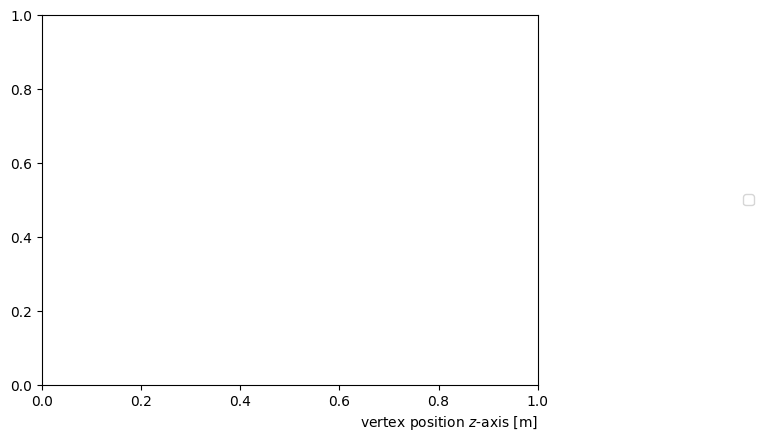

In [32]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "Si" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     